In [1]:
!pip install blackjax

In [2]:
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import time as t

import jax
import jax.numpy as jnp
import blackjax

from datetime import date

In [11]:
class SoftSpherePacking:
  def __init__(self, number_balls, dimensions, radius, alpha=0.4, beta=1., attractive=True):
    self.number_balls = number_balls
    self.dimensions = dimensions
    self.radius = radius
    self.alpha = alpha
    self.beta = beta
    self.attractive = attractive
    self.A = np.zeros([int(self.number_balls * (self.number_balls - 1) / 2), self.number_balls])
    self.origin = np.zeros((self.number_balls, self.dimensions)) + 0.5

    row = 0
    for i in range(self.number_balls - 1, 0, -1):
        self.A[row : row + i, self.number_balls - 1 - i] = np.ones(i)
        self.A[row : row + i, self.number_balls - i : self.number_balls] = -np.eye(i)
        row += i

  def cost(self, data):
    if self.attractive:
      cost_overlap = -(self.beta * jnp.sum(jnp.sqrt(jnp.sum((jnp.mod(data, 1) - self.origin) ** 2, axis=1))) / self.number_balls) + self.alpha * (self.beta * jnp.sum(jnp.sqrt(jnp.sum((jnp.mod(data, 1)[1:] - jnp.mod(data, 1)[:-1]) ** 2, axis=1))) / self.number_balls)
    else:
      cost_overlap = self.beta * jnp.sum(jnp.power(jnp.sum((jnp.mod(data, 1) - self.origin) ** 2, axis=1), 1./2.)) / self.number_balls
    return cost_overlap

def plot_circles(ax, centers, radii, color='black'):
    theta = np.linspace(0, 2 * np.pi, 100)
    for i in range(len(centers)):
        ax.plot(radii[i] * np.cos(theta) + centers[i, 0], radii[i] * np.sin(theta) + centers[i, 1], color=color)

In [12]:
%%time
number_balls = 20
dimensions = 2
radius = 0.1
initial_data = np.random.rand(number_balls, dimensions)
initial_position = {"data": initial_data}
# theta = np.linspace(0, 2 * np.pi, number_balls + 1)[:-1]
# initial_data = np.zeros((number_balls, dimensions))
# initial_data[:, 0] = 0.25 * np.cos(theta)
# initial_data[:, 1] = 0.25 * np.sin(theta)

CPU times: user 58 µs, sys: 4 µs, total: 62 µs
Wall time: 66.8 µs


In [13]:
DEFAULT_WARMUP_STEPS = 100
DEFAULT_STEP_SIZE = 0.033
DEFAULT_INVERSE_MASS_MATRIX = np.array([1])
class NutsWindowAdapt:
  def __init__(self, problem_instance, initial_position, warmup=True, warmup_steps=DEFAULT_WARMUP_STEPS):
    self.call_cost_function = lambda x : problem_instance.cost(**x)
    self.initial_position = initial_position
    self.warmup = warmup
    self.rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

    if warmup:
      warmup_sampler = blackjax.window_adaptation(blackjax.nuts, self.call_cost_function)
      _, warmup_key, self.sample_key = jax.random.split(self.rng_key, 3)
      (self.state, self.parameters), _ = warmup_sampler.run(warmup_key, self.initial_position, num_steps=warmup_steps)

  def inference_loop(self, rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

  def run(self, run_time, step_size=DEFAULT_STEP_SIZE, inverse_mass_matrix=DEFAULT_INVERSE_MASS_MATRIX):
    if self.warmup:
      kernel = blackjax.nuts(self.call_cost_function, **self.parameters).step
      states = self.inference_loop(self.sample_key, kernel, self.state, run_time)
    else:
      nuts_sampler = blackjax.nuts(self.call_cost_function, step_size, inverse_mass_matrix)
      initial_state = nuts_sampler.init(self.initial_position)
      _, sample_key = jax.random.split(self.rng_key)
      states = self.inference_loop(sample_key, nuts_sampler.step, initial_state, run_time)
    return states

In [14]:
bins = np.linspace(0, np.sqrt(2), 150)
g2_data = list()

for alpha in np.linspace(0.4, 0.5, 10):
  start_time = t.time()
  ssp = SoftSpherePacking(number_balls, dimensions, radius, alpha=alpha, beta=1024)
  nwa = NutsWindowAdapt(ssp, initial_position, warmup=True)
  history = nwa.run(1000)
  history.position["data"] = np.mod(history.position["data"], 1)
  history = history.position['data']

  plot_data = pdist(np.reshape(history[:], [-1, 2]))
  histogram_data, bins = np.histogram(plot_data.copy(), bins=bins)
  g2_data.append(histogram_data.copy() / (len(plot_data) * (bins[1:]**dimensions - bins[:-1]**dimensions)))
  print(f"Inverse temperature {np.round(beta, 4)}, time elapsed: {np.round(t.time() - start_time, 4)}")

Inverse temperature 1024, time elapsed: 28.4803
Inverse temperature 1024, time elapsed: 25.695
Inverse temperature 1024, time elapsed: 26.789
Inverse temperature 1024, time elapsed: 27.7893
Inverse temperature 1024, time elapsed: 27.1124
Inverse temperature 1024, time elapsed: 28.2215
Inverse temperature 1024, time elapsed: 27.3892
Inverse temperature 1024, time elapsed: 25.3883
Inverse temperature 1024, time elapsed: 25.6479
Inverse temperature 1024, time elapsed: 26.7065


(0.0, 10.0)

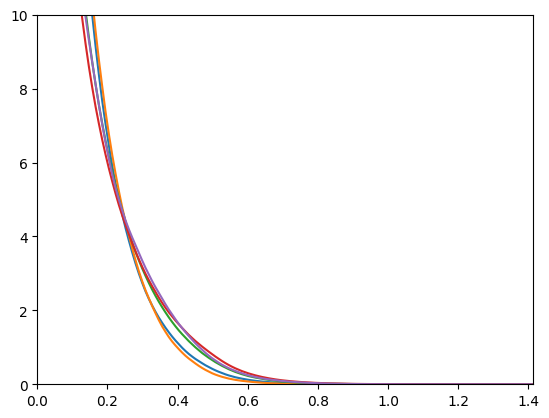

In [36]:
fig, ax0 = plt.subplots()
for i in np.delete(range(len(g2_data)), [5, 6, 7, 8, 9]):
  ax0.plot((bins[1:] + bins[:-1])/2, g2_data[i])
ax0.set_xlim([0, np.sqrt(2)])
ax0.set_ylim([0, 10])

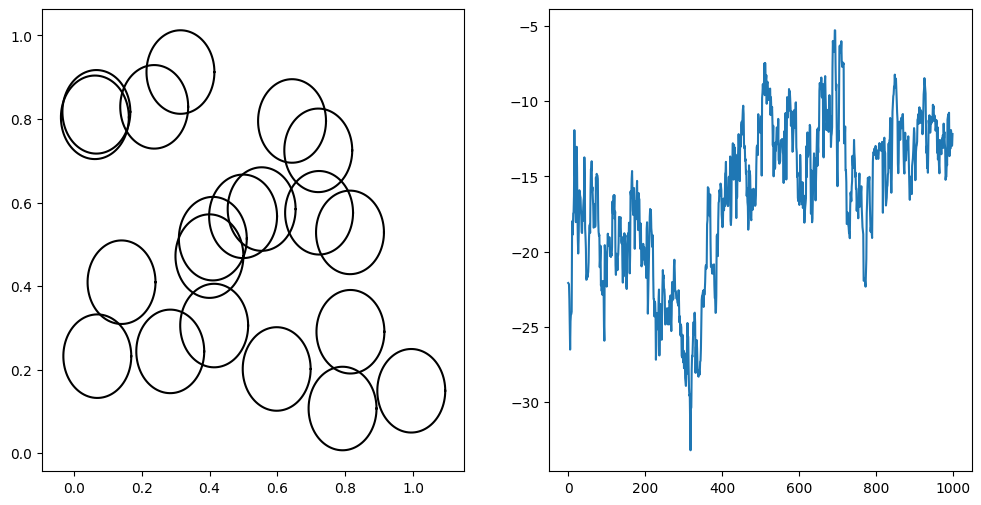

Array(-162.91968, dtype=float32)

In [39]:
frame=1
fig, (ax1, ax2) = plt.subplots(ncols=2, width_ratios=[1, 1], figsize=(12, 6))
centers = history[-frame]
radii = radius * np.ones(len(history[-frame]))
plot_circles(ax1, centers, radii)
# centers = initial_data
# plot_circles(ax1, centers, radii, 'blue')

energy_list = list()
for i in range(history.shape[0]):
  energy_list.append(ssp.cost(history[i]))
energy_list = np.array(energy_list)
ax2.plot(energy_list)
plt.show()

ssp.cost(initial_data)